# Analyse de sentiments - Twitter US Airline Sentiment

In [ ]:
#pip install tqdm
# !pip install numpy pandas matplotlib seaborn scikit-learn gensim nltk emoji joblib

In [6]:
# 1. Configuration initiale et importation des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import joblib
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import string
import emoji
import warnings
from collections import Counter
from time import time

# Configuration des options
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')
np.random.seed(37)

# Configuration de seaborn
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

# Téléchargement des ressources NLTK nécessaires
#nltk.download('punkt')
#nltk.download('stopwords')

In [7]:
# 2. Chargement et préparation des données

df = pd.read_csv("Tweets.csv")
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]

In [12]:
df.head()

,text,airline_sentiment
10620,@USAirways told to work it out ourselves #joke #fail,negative
13609,@AmericanAir that all AA is for USAir Elite members. It's one big disappointment in the way we are treated. #epicfailure,negative
2955,@united Bummer. Might have to go with @AmericanAir card instead. TY for response though.,negative
3585,@united well the income flight to dca to take us to ewr was delayed and it made us miss our connection to FLL so yes hotels were necessary,negative
2087,@united we have tried to change our flight THREE times on the phone and got disconnected each time.,negative


## Analyse Exploratoire des Données

Le code suivant effectue une analyse exploratoire des données sur un ensemble de tweets concernant des compagnies aériennes. Il commence par importer les bibliothèques nécessaires pour la manipulation des données, le traitement du texte, et la visualisation. La pièce maîtresse du code est la classe TextCounts, un transformateur personnalisé conçu pour extraire diverses caractéristiques textuelles des tweets, telles que le nombre de mots, de mentions, de hashtags, de mots en majuscules, de marques de ponctuation, d'URLs et d'emojis. Cette classe utilise des expressions régulières pour compter ces éléments et retourne les résultats dans un DataFrame.

Le code inclut également une fonction show_dist pour visualiser la distribution des caractéristiques extraites, segmentée par sentiment. Après avoir appliqué le transformateur TextCounts aux tweets, le code ajoute la colonne de sentiment au DataFrame résultant. Enfin, il utilise seaborn pour tracer un graphique en barres montrant la distribution globale des sentiments dans le dataset. Ce code forme la base d'une analyse exploratoire approfondie des données textuelles des tweets, permettant d'examiner diverses caractéristiques linguistiques et leur relation avec le sentiment exprimé envers les compagnies aériennes.

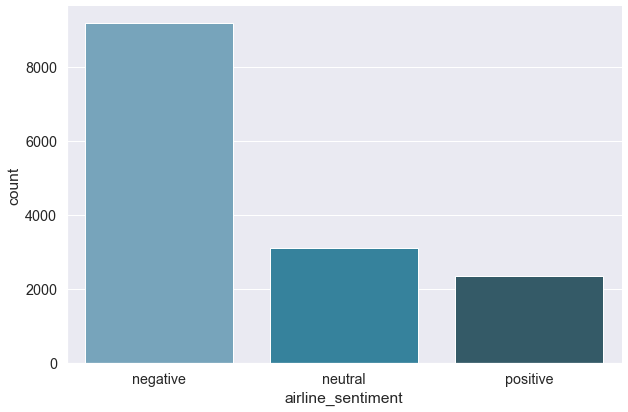

In [8]:
import pandas as pd
import numpy as np
import re
import emoji
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin

# 3. Analyse exploratoire des données
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        count_emojis = X.apply(lambda x: emoji.emoji_count(x))
        
        df = pd.DataFrame({
            'count_words': count_words,
            'count_mentions': count_mentions,
            'count_hashtags': count_hashtags,
            'count_capital_words': count_capital_words,
            'count_excl_quest_marks': count_excl_quest_marks,
            'count_urls': count_urls,
            'count_emojis': count_emojis
        })
        
        return df

def show_dist(df, col):
    print(f'Descriptive stats for {col}')
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', height=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.histplot, col, kde=False, stat="density", bins=bins)
    plt.show()


tc = TextCounts()
df_eda = tc.fit_transform(df['text'])
df_eda['airline_sentiment'] = df['airline_sentiment']

# Visualisation de la distribution des sentiments
sns.catplot(x="airline_sentiment", data=df, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
plt.show()

Descriptive stats for count_words
---------------------------------
                    count       mean       std  min   25%   50%   75%   max
airline_sentiment                                                          
negative           9178.0  20.387557  6.100020  2.0  17.0  22.0  25.0  35.0
neutral            3099.0  15.290094  7.150738  2.0  10.0  15.0  21.0  34.0
positive           2363.0  14.478206  7.266129  2.0   8.0  14.0  21.0  33.0


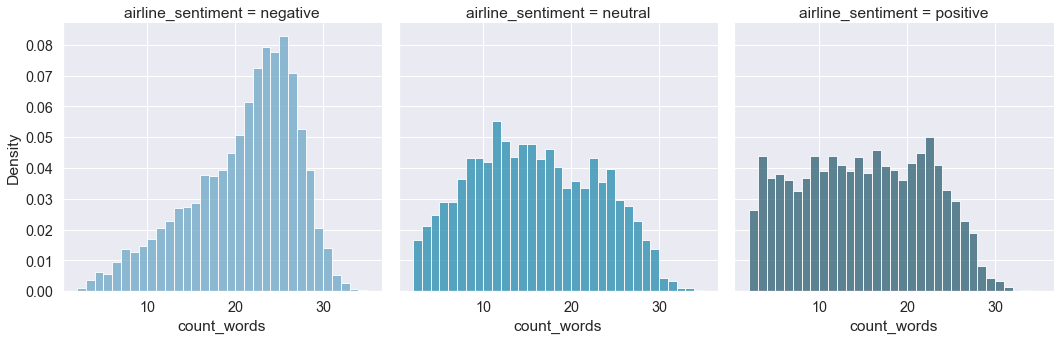

In [9]:
# Pour visualiser la distribution d'une caractéristique spécifique
show_dist(df_eda, 'count_words')  # Décommentez cette ligne pour l'utiliser

## Nettoyage de données

Le code suivant définit une classe CleanText qui hérite de BaseEstimator et TransformerMixin de scikit-learn, conçue pour nettoyer et prétraiter le texte des tweets. La classe comprend plusieurs méthodes de nettoyage, chacune responsable d'une tâche spécifique : suppression des mentions (@utilisateur), des URLs, uniformisation des emojis, suppression de la ponctuation et des chiffres, conversion en minuscules, élimination des mots vides (stopwords), et racinisation (stemming). La méthode transform applique ces opérations de nettoyage en séquence sur le texte d'entrée. Le code se termine par la création d'une instance de CleanText et son application sur la colonne 'text' du DataFrame df, produisant une série de tweets nettoyés.

Ce processus de nettoyage est une étape cruciale dans le prétraitement des données textuelles pour l'analyse de sentiment ou d'autres tâches de traitement du langage naturel. Il vise à réduire le bruit dans les données, à normaliser le texte et à le préparer pour les étapes ultérieures de l'analyse, comme la vectorisation ou la modélisation. Le nettoyage permet de se concentrer sur le contenu significatif des tweets en éliminant les éléments non pertinents ou redondants, ce qui peut améliorer la performance des modèles d'apprentissage automatique appliqués par la suite.

In [11]:
df_eda.head(5)

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,airline_sentiment
10620,9,1,2,0,0,0,0,negative
13609,21,1,1,1,0,0,0,negative
2955,14,2,0,1,0,0,0,negative
3585,28,1,0,1,0,0,0,negative
2087,18,1,0,1,0,0,0,negative


In [10]:
# 4. Nettoyage du texte

class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')
        return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

ct = CleanText()
sr_clean = ct.fit_transform(df.text)

## Modélisation

Dans la suite, le code prépare les données pour l'entraînement d'un modèle d'apprentissage automatique. Il commence par créer un nouveau DataFrame df_model en combinant les caractéristiques extraites précédemment (df_eda) avec le texte nettoyé (sr_clean). Ensuite, il affiche la liste des colonnes du DataFrame pour vérifier sa structure. La partie principale du code utilise la fonction train_test_split de scikit-learn pour diviser les données en ensembles d'entraînement et de test, avec 90% des données pour l'entraînement et 10% pour le test.

La classe ColumnExtractor est définie comme un transformateur personnalisé qui permet de sélectionner des colonnes spécifiques d'un DataFrame. Cette classe sera utile dans un pipeline de modélisation pour extraire les colonnes pertinentes à chaque étape du processus. Enfin, le code répète l'opération de division des données, probablement par inadvertance. Cette préparation des données est une étape cruciale dans le processus de modélisation, permettant de structurer les données de manière appropriée pour l'entraînement et l'évaluation du modèle, tout en fournissant des outils flexibles (comme ColumnExtractor) pour manipuler les données dans le pipeline de modélisation.

In [13]:
# 5. Préparation des données pour le modèle

df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)


In [14]:
#6. Sélection des colonnes
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)


Le code suivant définit une fonction grid_vect et des dictionnaires de paramètres pour effectuer une recherche par grille (grid search) sur différents modèles de classification de texte. Voici un résumé en deux paragraphes :

La fonction grid_vect est conçue pour effectuer une recherche par grille sur un classificateur donné, en utilisant soit des caractéristiques de texte extraites (textcounts) soit une combinaison de ces caractéristiques avec des vecteurs de mots (word2vec ou vectorisation de texte classique). Elle utilise FeatureUnion et Pipeline de scikit-learn pour combiner différentes étapes de prétraitement et de classification. La fonction effectue la recherche par grille, affiche les meilleurs paramètres trouvés, évalue le modèle sur l'ensemble de test et affiche un rapport de classification détaillé. Cette approche permet d'optimiser automatiquement les hyperparamètres du modèle et du prétraitement du texte simultanément.

Les dictionnaires parameters_vect, parameters_mnb, et parameters_logreg définissent les grilles de paramètres à explorer pour différentes parties du pipeline. parameters_vect concerne la vectorisation du texte, spécifiant des options pour la fréquence maximale des documents (max_df), la plage de n-grammes, et la fréquence minimale des documents (min_df). parameters_mnb définit les valeurs à tester pour le paramètre alpha du classificateur Naive Bayes multinomial, tandis que parameters_logreg spécifie les valeurs à explorer pour le paramètre C et le type de pénalité de la régression logistique. Ces grilles de paramètres permettent une exploration systématique de l'espace des hyperparamètres pour trouver la meilleure configuration du modèle.

In [24]:
# 7. Hyperparamètres et validations croisées et métriques
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)
    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [25]:
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}
# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}
# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [26]:
#8. Modélisations
mnb = MultinomialNB()
logreg = LogisticRegression()

Avant d'appliquer les modèles, il faut toujours transformer les données textuelles en données numériques.
Ici, nous appliquons le sac de mots et le tf-idf pour retenir le plus performant sur nos données.

In [27]:
countvect = CountVectorizer()
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'features__pipe__vect__max_df': (0.25, 0.5, 0.75), 'features__pipe__vect__ngram_range': ((1, 1), (1, 2)), 'features__pipe__vect__min_df': (1, 2), 'clf__alpha': (0.25, 0.5, 0.75)}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
done in 30.235s

Best CV score: 0.775
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.784


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.82      0.91      0.86       911
     neutral       0.67      0.48      0.56       320
    positive       0.76      0.72      0.74       233

    accuracy                           0.78      1464
   macro avg       0.75      0.70      0.72      1464
weighted avg       0.77      0.78      0.77      1464

Performing grid search...
pipeline: ['features', 

In [28]:
tfidfvect = TfidfVectorizer()
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'features__pipe__vect__max_df': (0.25, 0.5, 0.75), 'features__pipe__vect__ngram_range': ((1, 1), (1, 2)), 'features__pipe__vect__min_df': (1, 2), 'clf__alpha': (0.25, 0.5, 0.75)}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
done in 30.512s

Best CV score: 0.748
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.750


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.74      0.97      0.84       911
     neutral       0.76      0.29      0.42       320
    positive       0.79      0.50      0.61       233

    accuracy                           0.75      1464
   macro avg       0.77      0.59      0.63      1464
weighted avg       0.76      0.75      0.72      1464

Performing grid search...
pipeline: ['features'

## Analyse sémantique

On initialise et on utilise un modèle Word2Vec pour créer des représentations vectorielles de mots à partir des tweets nettoyés. 

Le code commence par définir SIZE à 50, qui représente la dimension des vecteurs de mots. Ensuite, il tokenise le texte nettoyé dans les ensembles d'entraînement et de test, créant une nouvelle colonne 'clean_text_wordlist' contenant des listes de mots pour chaque tweet. Cette étape est nécessaire pour préparer les données pour l'entraînement du modèle Word2Vec. Un modèle Word2Vec est alors initialisé et entraîné sur les listes de mots de l'ensemble d'entraînement, avec des paramètres spécifiques : min_count=1 (inclure tous les mots), window=5 (contexte de 5 mots), et workers=4 (utiliser 4 threads pour l'entraînement).

Après l'entraînement, le code utilise la méthode most_similar pour trouver les 3 mots les plus similaires au mot 'plane' selon le modèle Word2Vec. Cette opération démontre l'utilité du modèle pour capturer les relations sémantiques entre les mots dans le contexte spécifique des tweets sur les compagnies aériennes. L'utilisation de Word2Vec permet de transformer les mots en vecteurs denses, capturant ainsi des informations sémantiques qui peuvent être utiles pour des tâches d'analyse de sentiment ou de classification de texte plus avancées.

In [48]:
SIZE = 50
X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))
model = gensim.models.Word2Vec(X_train.clean_text_wordlist
, min_count=1
, window=5
, workers=4)
model.wv.most_similar('plane', topn=3)

[('tarmac', 0.9988699555397034),
 ('gate', 0.9978677034378052),
 ('sit', 0.9978242516517639)]

On définit une fonction compute_avg_w2v_vector et l'utilise pour transformer les tweets en vecteurs Word2Vec moyens.

La fonction compute_avg_w2v_vector prend en entrée un dictionnaire de vecteurs de mots (w2v_dict) et un tweet tokenisé. Elle calcule le vecteur moyen du tweet en faisant la moyenne des vecteurs de mots présents dans le dictionnaire Word2Vec. Si aucun mot du tweet n'est présent dans le dictionnaire, elle retourne un vecteur de zéros de la même dimension que les vecteurs de mots. Cette approche permet de représenter chaque tweet par un vecteur unique, capturant le sens global du tweet à partir des représentations vectorielles de ses mots individuels.

Ensuite, le code applique cette fonction à chaque tweet dans les ensembles d'entraînement (X_train) et de test (X_test), créant ainsi X_train_w2v et X_test_w2v. Ces nouvelles variables contiennent les représentations vectorielles moyennes de chaque tweet, basées sur le modèle Word2Vec précédemment entraîné. Cette transformation convertit les tweets de séquences de mots en vecteurs numériques de dimension fixe, ce qui les rend utilisables comme entrées pour des algorithmes d'apprentissage automatique classiques. 

Cette représentation capture des informations sémantiques des tweets qui peuvent être utiles pour des tâches de classification ou d'analyse de sentiment.

In [53]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.key_to_index]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0] * w2v_dict.vector_size
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result

X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [54]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)
# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [56]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
done in 4.052s

Best CV score: 0.689
Best parameters set:
	clf__C: 0.5
	clf__penalty: 'l2'
Test score with best_estimator_: 0.687


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.70      0.95      0.81       911
     neutral       0.55      0.21      0.31       320
    positive       0.65      0.31      0.42       233

    accuracy                           0.69      1464
   macro avg       0.63      0.49      0.51      1464
weighted avg       0.66      0.69      0.64      1464



## Applications à de nouvelles données

In [58]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
,'count_mentions','count_urls','count_words']

features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
, ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
, ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
, n_jobs=-1)
pipeline = Pipeline([
('features', features)
, ('clf', LogisticRegression(C=1.0, penalty='l2'))
])

best_model = pipeline.fit(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment)

In [59]:
# Application sur un nouveau tweet positif

new_positive_tweets = pd.Series(["Thank you @VirginAmerica for you amazing customer support team on Tuesday 11/28 at @EWRairport and returning my lost bag in less than 24h! #efficiencyiskey #virginamerica"
,"Love flying with you guys ask these years. Sad that this will be the last trip 😂 @VirginAmerica #LuxuryTravel"
,"Wow @VirginAmerica main cabin select is the way to fly!! This plane is nice and clean & I have tons of legroom! Wahoo! NYC bound! ✈️"])

df_counts_pos = tc.transform(new_positive_tweets)
df_clean_pos = ct.transform(new_positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos

best_model.predict(df_model_pos).tolist()

['positive', 'positive', 'positive']

In [61]:
# Application sur un nouveau tweet négatif

new_negative_tweets = pd.Series(["@VirginAmerica shocked my initially with the service, but then went on to shock me further with no response to what my complaint was. #unacceptable @Delta @richardbranson"
,"@VirginAmerica this morning I was forced to repack a suitcase w a medical device because it was barely overweight - wasn't even given an option to pay extra. My spouses suitcase then burst at the seam with the added device and had to be taped shut. Awful experience so far!"
,"Board airplane home. Computer issue. Get off plane, traverse airport to gate on opp side. Get on new plane hour later. Plane too heavy. 8 volunteers get off plane. Ohhh the adventure of travel ✈️ @VirginAmerica"])

df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg

best_model.predict(df_model_neg).tolist()

['negative', 'negative', 'negative']